# Data Workflow: NYC Airbnb Open Data Analysis

**Author:** Tim Wilcoxson
**Dataset:** NYC Airbnb Open Data (2019) — 48,895 listings across five boroughs
**Date:** February 2026

This project demonstrates a reproducible data workflow using Python, Pandas, and
Seaborn. I ingest, clean, explore, and visualize the NYC Airbnb Open Data to
uncover pricing patterns, geographic distributions, and room-type compositions
across New York City's five boroughs.

## 0. Setup

Import required libraries and configure display and plot settings.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress non-critical warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Display options
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", "{:.2f}".format)

# Plot style
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

print("Setup complete.")

Setup complete.


## 1. Data Ingestion

I load the CSV directly from the project directory. The dataset was originally
published on Kaggle by Dgomonov and contains information about Airbnb listings
in New York City for 2019.

In [2]:
df_raw = pd.read_csv("AB_NYC_2019.csv")

print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns\n")
df_raw.head(10)

Shape: 48,895 rows × 16 columns



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.75,-73.97,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.69,-73.96,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76,-73.98,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80,-73.97,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71,-73.99,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [3]:
print("Data types:")
print(df_raw.dtypes)
print(f"\nMemory usage: {df_raw.memory_usage(deep=True).sum() / 1e6:.1f} MB")

Data types:
id                                  int64
name                                  str
host_id                             int64
host_name                             str
neighbourhood_group                   str
neighbourhood                         str
latitude                          float64
longitude                         float64
room_type                             str
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                           str
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

Memory usage: 22.3 MB


In [4]:
print("Missing values per column:\n")
missing = df_raw.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))
print(f"\nTotal missing cells: {df_raw.isnull().sum().sum():,}")

Missing values per column:

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64

Total missing cells: 20,141


In [5]:
df_raw.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,48895.00,38843.00,48895.00,48895.00
mean,19017143.24,67620010.65,40.73,-73.95,152.72,7.03,23.27,1.37,7.14,112.78
std,10983108.39,78610967.03,0.05,0.05,240.15,20.51,44.55,1.68,32.95,131.62
min,2539.00,2438.00,40.50,-74.24,0.00,1.00,0.00,0.01,1.00,0.00
25%,9471945.00,7822033.00,40.69,-73.98,69.00,1.00,1.00,0.19,1.00,0.00
50%,19677284.00,30793816.00,40.72,-73.96,106.00,3.00,5.00,0.72,1.00,45.00
75%,29152178.50,107434423.00,40.76,-73.94,175.00,5.00,24.00,2.02,2.00,227.00
max,36487245.00,274321313.00,40.91,-73.71,10000.00,1250.00,629.00,58.50,327.00,365.00


### Observations on Raw Data

- **48,895 rows** and **16 columns** loaded successfully.
- `reviews_per_month` has ~10,052 nulls — these correspond to listings with zero
  reviews that have never been reviewed.
- `last_review` has the same ~10,052 nulls, consistent with the above.
- `name` (16 nulls) and `host_name` (21 nulls) have minor missing values.
- The `price` column ranges from \$0 to \$10,000, so there are definitely outliers on both ends.
- `minimum_nights` reaches 1,250 days, indicating some listings are effectively
  long-term rentals rather than typical short-stay Airbnb units.

## 2. Data Cleaning

I followed tidy data principles (Wickham, 2014) for cleaning — each variable gets its own column, each observation is a row, and each type of data forms its own table. The main issues to address were missing values, unparsed date strings, and price outliers that would throw off the analysis.

In [6]:
def handle_missing_values(df):
    """Handle missing values in the Airbnb dataset.

    Strategy:
    - reviews_per_month: Fill with 0.0 (no reviews means zero monthly rate).
    - last_review: Parse to datetime; NaT for never-reviewed listings is valid.
    - name / host_name: Fill with 'Unknown' to preserve row count.

    Parameters
    ----------
    df : pd.DataFrame
        Raw Airbnb dataframe.

    Returns
    -------
    pd.DataFrame
        Dataframe with missing values handled.
    """
    df = df.copy()
    df["reviews_per_month"] = df["reviews_per_month"].fillna(0.0)
    df["last_review"] = pd.to_datetime(df["last_review"], format="mixed")
    df["name"] = df["name"].fillna("Unknown")
    df["host_name"] = df["host_name"].fillna("Unknown")
    return df

In [7]:
def remove_price_outliers(df, lower=1, upper_quantile=0.99):
    """Remove price outliers from the dataset.

    Listings priced at $0 are likely errors or inactive entries. Extreme high
    prices above the 99th percentile are removed to prevent skewing
    summary statistics and visualizations.

    Parameters
    ----------
    df : pd.DataFrame
        Airbnb dataframe with a 'price' column.
    lower : int or float
        Minimum valid price (exclusive lower bound for removal). Default 1.
    upper_quantile : float
        Quantile threshold for upper bound. Default 0.99.

    Returns
    -------
    pd.DataFrame
        Filtered dataframe with outliers removed.
    """
    upper_bound = df["price"].quantile(upper_quantile)
    mask = (df["price"] >= lower) & (df["price"] <= upper_bound)
    removed = len(df) - mask.sum()
    print(f"Upper bound (p{upper_quantile*100:.0f}): ${upper_bound:,.0f}")
    print(f"Rows removed: {removed:,} ({removed/len(df)*100:.1f}%)")
    return df[mask].reset_index(drop=True)

In [8]:
print(f"Before cleaning: {df_raw.shape[0]:,} rows")
print(f"Missing values: {df_raw.isnull().sum().sum():,}\n")

df = handle_missing_values(df_raw)
print(f"After handling missing values: {df.isnull().sum().sum()} missing cells")
print(f"  (remaining nulls are NaT values in last_review — intentionally preserved)")
print(f"  last_review dtype: {df['last_review'].dtype}\n")

df = remove_price_outliers(df)
print(f"\nAfter cleaning: {df.shape[0]:,} rows")

Before cleaning: 48,895 rows
Missing values: 20,141

After handling missing values: 10052 missing cells
  (remaining nulls are NaT values in last_review — intentionally preserved)
  last_review dtype: datetime64[us]

Upper bound (p99): $799
Rows removed: 485 (1.0%)

After cleaning: 48,410 rows


### Cleaning Summary

| Issue | Decision | Rationale |
|---|---|---|
| `reviews_per_month` nulls | Filled with 0.0 | Nulls represent listings with no reviews; zero is the right value since they genuinely have no review activity |
| `last_review` nulls | Kept as NaT after datetime parsing | Absence of a review date is meaningful, not an error |
| `name` / `host_name` nulls | Filled with "Unknown" | Keeps the row count intact so we don't lose data for numeric columns |
| Price = $0 | Removed | Likely inactive or erroneous listings |
| Price > 99th percentile | Removed | Extreme values distort summary statistics and visualizations |

The goal was to keep as much usable data as possible while getting rid of values that are clearly wrong or would skew the results.

## 3. Exploratory Data Analysis

In [9]:
def summarize_by_group(df, group_col, agg_col="price", agg_funcs=None):
    """Compute grouped summary statistics sorted by median.

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned Airbnb dataframe.
    group_col : str
        Column to group by (e.g., 'neighbourhood_group', 'room_type').
    agg_col : str
        Numeric column to aggregate. Default 'price'.
    agg_funcs : list of str or None
        Aggregation functions. Default: count, mean, median, std, min, max.

    Returns
    -------
    pd.DataFrame
        Summary table sorted by median descending.
    """
    if agg_funcs is None:
        agg_funcs = ["count", "mean", "median", "std", "min", "max"]
    summary = df.groupby(group_col)[agg_col].agg(agg_funcs)
    return summary.sort_values("median", ascending=False)

In [10]:
print("=== Price by Borough ===\n")
summarize_by_group(df, "neighbourhood_group")

=== Price by Borough ===



,count,mean,median,std,min,max
neighbourhood_group,,,,,,
Manhattan,21312,172.90,149.00,116.47,10,799
Brooklyn,19992,115.92,90.00,85.88,10,795
Queens,5650,94.10,75.00,69.19,10,750
Staten Island,369,94.24,75.00,75.69,13,700
Bronx,1087,83.86,65.00,69.39,10,680


In [11]:
print("=== Price by Room Type ===\n")
summarize_by_group(df, "room_type")

=== Price by Room Type ===



,count,mean,median,std,min,max
room_type,,,,,,
Entire home/apt,25022,189.10,160.00,109.66,10,799
Private room,22237,83.39,70.00,59.37,10,799
Shared room,1151,64.20,45.00,60.66,10,725


In [12]:
print("=== Listing Counts by Borough and Room Type ===\n")
ct = pd.crosstab(df["neighbourhood_group"], df["room_type"], margins=True)
print(ct)

=== Listing Counts by Borough and Room Type ===

room_type            Entire home/apt  Private room  Shared room    All
neighbourhood_group                                                   
Bronx                            378           650           59   1087
Brooklyn                        9480         10101          411  19992
Manhattan                      12905          7930          477  21312
Queens                          2087          3368          195   5650
Staten Island                    172           188            9    369
All                            25022         22237         1151  48410


In [13]:
print("=== Correlation Matrix (numeric columns) ===\n")
numeric_cols = ["price", "minimum_nights", "number_of_reviews",
                "reviews_per_month", "calculated_host_listings_count",
                "availability_365"]
corr = df[numeric_cols].corr()
print(corr.round(2))

=== Correlation Matrix (numeric columns) ===

                                price  minimum_nights  number_of_reviews  reviews_per_month  \
price                            1.00            0.02              -0.06              -0.05   
minimum_nights                   0.02            1.00              -0.08              -0.13   
number_of_reviews               -0.06           -0.08               1.00               0.59   
reviews_per_month               -0.05           -0.13               0.59               1.00   
calculated_host_listings_count   0.15            0.13              -0.07              -0.05   
availability_365                 0.11            0.14               0.17               0.17   

                                calculated_host_listings_count  availability_365  
price                                                     0.15              0.11  
minimum_nights                                            0.13              0.14  
number_of_reviews                      

## 4. Visualizations

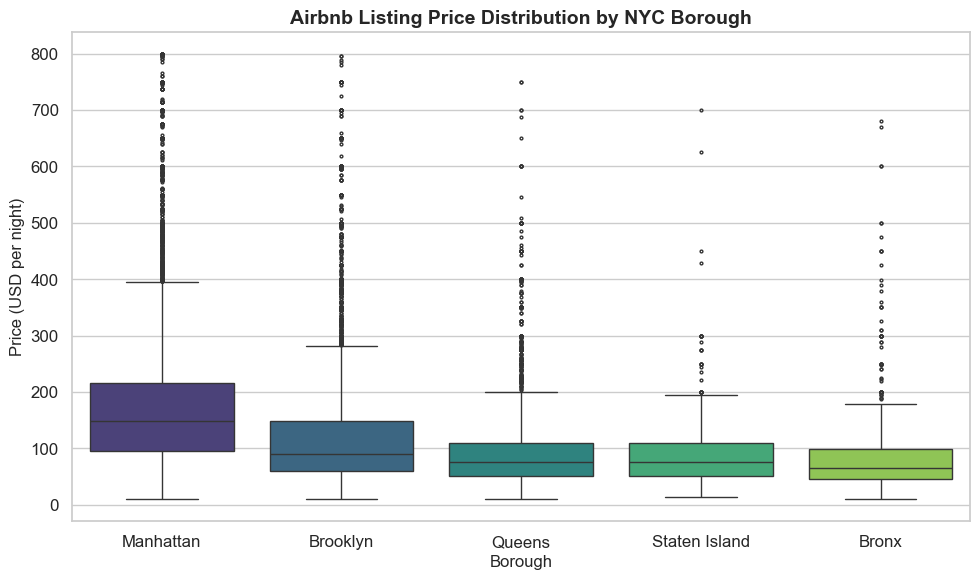

In [14]:
# Visualization 1: Price Distribution by Borough
borough_order = (df.groupby("neighbourhood_group")["price"]
                 .median().sort_values(ascending=False).index)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="neighbourhood_group",
    y="price",
    hue="neighbourhood_group",
    order=borough_order,
    hue_order=borough_order,
    palette="viridis",
    legend=False,
    fliersize=2,
    ax=ax,
)
ax.set_title("Airbnb Listing Price Distribution by NYC Borough", fontsize=14, fontweight="bold")
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Price (USD per night)", fontsize=12)
plt.tight_layout()
plt.savefig("viz1_price_by_borough.png", dpi=150, bbox_inches="tight")
plt.show()

### Interpretation — Figure 1: Price Distribution by Borough

Manhattan has the highest median nightly price, with a wide interquartile range —
it has everything from budget shared rooms to luxury apartments, so the spread
makes sense. Brooklyn comes in second. Staten Island, the Bronx, and Queens have
tighter price ranges and lower medians, which tracks since they're farther from
the main tourist and business areas. All boroughs show right-skewed distributions
with upper outliers, though Manhattan's extend considerably higher.

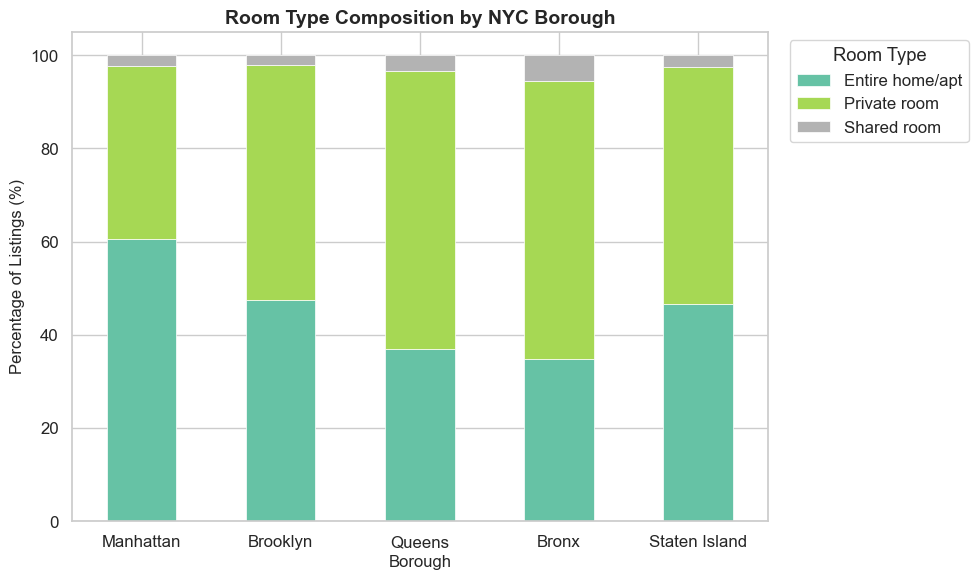

In [15]:
# Visualization 2: Room Type Composition by Borough
ct_pct = pd.crosstab(
    df["neighbourhood_group"], df["room_type"], normalize="index"
) * 100

# Sort boroughs by total listing count
borough_order_count = df["neighbourhood_group"].value_counts().index

fig, ax = plt.subplots(figsize=(10, 6))
ct_pct.loc[borough_order_count].plot(
    kind="bar",
    stacked=True,
    colormap="Set2",
    edgecolor="white",
    linewidth=0.5,
    ax=ax,
)
ax.set_title("Room Type Composition by NYC Borough", fontsize=14, fontweight="bold")
ax.set_xlabel("Borough", fontsize=12)
ax.set_ylabel("Percentage of Listings (%)", fontsize=12)
ax.legend(title="Room Type", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig("viz2_room_type_composition.png", dpi=150, bbox_inches="tight")
plt.show()

### Interpretation — Figure 2: Room Type Composition by Borough

Manhattan has the highest share of entire home/apartment listings (~60%), which
makes sense — a lot of those are probably being used as hotel alternatives.
Brooklyn is more evenly split between entire homes and private rooms. Queens,
the Bronx, and Staten Island lean more toward private rooms, which suggests
hosts in those areas are more likely renting out a spare room rather than
listing a whole apartment. Shared rooms are a small slice everywhere.

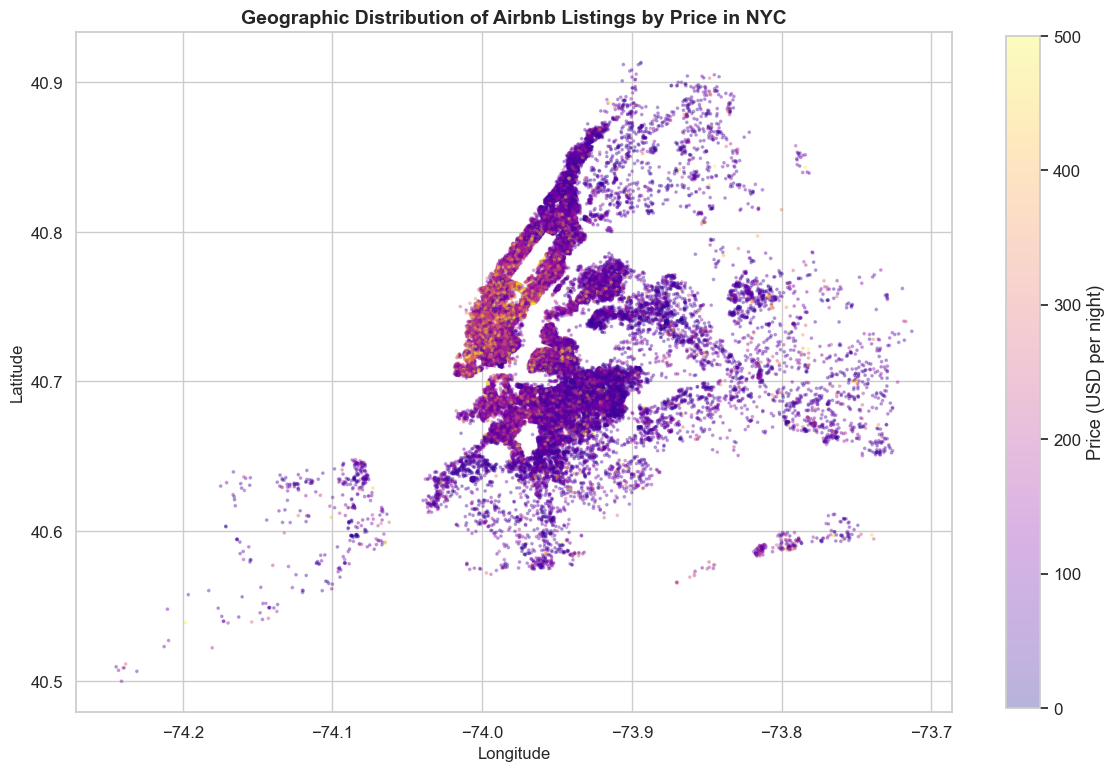

In [16]:
# Visualization 3: Geographic Scatter by Price
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(
    df["longitude"],
    df["latitude"],
    c=df["price"],
    cmap="plasma",
    alpha=0.3,
    s=3,
    vmin=0,
    vmax=500,
)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, label="Price (USD per night)")
ax.set_title(
    "Geographic Distribution of Airbnb Listings by Price in NYC",
    fontsize=14,
    fontweight="bold",
)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.set_aspect("equal")
plt.tight_layout()
plt.savefig("viz3_geographic_scatter.png", dpi=150, bbox_inches="tight")
plt.show()

### Interpretation — Figure 3: Geographic Distribution by Price

The scatter plot reveals the geographic footprint of NYC's Airbnb market. High-price
listings (bright/yellow tones) cluster heavily in lower and midtown Manhattan, as
well as along the Brooklyn waterfront near Williamsburg and DUMBO. The outer
boroughs show predominantly lower prices (darker tones) with more uniform
distributions. Listing density is highest in Manhattan and northwest Brooklyn,
which lines up with where most of the short-term rental activity is. Staten Island
has noticeably sparser coverage, which fits since it gets far less tourist traffic.

## 5. Summary

### Key Insights

1. **Manhattan dominates pricing:** Median nightly prices in Manhattan ($149)
   are well above every other borough, which isn't surprising given the
   concentration of tourist and business activity there.

2. **Room type varies by borough:** Entire home/apartment listings make up
   about 60% of Manhattan's supply, while outer boroughs lean toward private
   rooms — probably because hosts there are more likely renting a spare room
   in their own place.

3. **Geographic clustering:** High-price listings cluster along Manhattan's
   core and the Brooklyn waterfront, with prices dropping off as you move
   into the outer boroughs.

4. **Weak inverse relationship between price and reviews:** The correlation
   between price and review count is slightly negative (r = -0.06),
   which makes sense — cheaper listings probably get booked more often
   and end up with more reviews over time.

### Patterns

- Price distributions are right-skewed across all boroughs, with Manhattan
  showing the widest spread (std = $116 vs. $69–$86 for other boroughs).
- The Bronx and Staten Island have far fewer listings (1,087 and 369
  respectively) and lower median prices than the other three boroughs.
- Entire home/apartment listings command roughly double the median price
  ($160) compared to private rooms ($70), so room type is the single
  biggest factor in what a listing costs.

### Assumptions and Limitations

- **Price = $0 removed:** I assumed these are inactive or erroneous entries,
  but some could be promotional listings.
- **99th percentile cutoff:** The upper bound removal is a common but
  arbitrary threshold — results would shift under different cutoffs.
- **Snapshot data:** This is a single point-in-time dataset (2019), so I
  can't infer trends or seasonal patterns from it.
- **Self-reported data:** Prices are whatever hosts decided to list and may
  not reflect actual booking rates or what guests ended up paying.

### Reproducibility

I built this workflow to be reproducible, following practices from Danchev (2022).
All the data transformations live in documented Python functions, dependencies
are pinned in `requirements.txt`, and everything is tracked in Git. The dataset
is included in the repository so the notebook runs immediately after cloning
without external downloads.